# EVCSAP Stochastic Programming
*Author: Gen LI; Date: 14.11.22*


In [3]:
# Import local scripts
import os, sys
currentdir = os.path.dirname(os.path.realpath('MPSP_CSAP_29Nov_developing.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from csap_packages_sp import sp_data_process as Dap
# from csap_packages_sp import sp_model_setup as Sup
from csap_packages_sp import sp_model_setup_by_fm_data as SupSP
from csap_packages_sp import sp_stat_compu as Stac
from csap_packages_sp import sp_sce_generation as Sceg
from csap_packages_sp.sp_mpd_frame_model_setup import _build_mpdp_csap_frame


# Import external packages
import idaes
import numpy as np
import pandas as pd
import geopandas as gpd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyproj import CRS
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from cProfile import label
import plotly.express as px
from pyomo.core.expr.current import evaluate_expression
import time
import pickle
import seaborn
from mpisppy.opt.ef import ExtensiveForm

# seaborn.set_theme(context = 'notebook', style = 'whitegrid')

# np.random.seed(121022)

ModuleNotFoundError: No module named 'csap_packages_sp'

In [27]:
import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_connection(
    df: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph',
    plot_mode: str = 'relative',
    legend_text: str = "legend_text 2b defined"
    ):
    df_copy = df.copy()
    columns = df_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': r'$\phi^{II} \; \text{[m]} $', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_copy, x=df_copy.index.astype(str), 
            y=columns, 
#             facet_col = columns,
#             title=plot_name, 
#             text_auto = True,
            barmode = plot_mode, #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
            # marginal = "histogram",
            # marginal_y = "violin",
            # opacity = 0.7,                       
        )
#     print(plot_labels)

#         trace_cols_of_interest = ['sum']
#         for col in cols_of_interest:
#         fig.add_trace(
#              go.Scatter(
#         #          wide_df,
#                 x=df_copy.index, 
#                 y=df_copy[columns], 
#                 mode="lines",
#                 line=go.scatter.Line(
#         #          color="gray"
#              ),
#                 showlegend=True,
#                  opacity = 0.7,
# #                  name = f'sum'
#              )
#         )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="top",
        y=1.00,
        xanchor="center",
        x=1.15
    ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
      legend_title_text=f'{legend_text}',
          title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
     )
    fig.show()


## Section 1: Pre-process Geo-data to get Setup Dictionary for pyomo model

In [5]:
#########################################################
#### Load Data from OSM, Sythetic, OCM, DE Bundesamt #### 

# --- Load Schutter Wald OSM Data (Resource from hdgb API by Domenico) --- # 
geojson_folder = r"C:\Users\z004ffpm\Work_Documents\MyExtractedData\hdgb\77746\geojson"
geojson_filename = r"\evcsap_77746_ss.geojson"
filepath = geojson_folder + geojson_filename
SW_gdf = gpd.read_file(filepath)

# --- Load Synthetic Substations Data for SW (Resource from Domenico) --- #
path_synthetic_ss_SW =  r"C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Data\SW_transformers.csv"
df = pd.read_csv(path_synthetic_ss_SW)
df['element'] = 'substations' # We keep the 'tag' == 'transformers', for later reference that these data are synthetic
syn_ss_SW_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# --- Load existing old CSs from OCM --- #
# # There's no CS data for Schutterwald on OCM, thus jump this step. (Resouce from Sisi)
# df_ocm = pd.read_csv('./ocm.csv')

# --- Load existing old CSs from "Ladesaeulenregistered" by DE Bundesamt --- #
df_DE_Gov = pd.read_csv(
    r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Ladesaeulenregister_CSV.csv', 
    encoding = "ISO-8859-1", # "utf-8", 
    header = 10, 
    sep = ';'
    )
# df_DE_Gov.head(3)
oldCS_df_SW = df_DE_Gov[df_DE_Gov.Postleitzahl == 77746] # EDEKA Oberle Getränkemarkt

#########################################################################################
#### Process loaded data, define single-period and multi-period deterministic data ######

# --- concat OSM and Synthetic data for SW --- #
SW_concat_gdf = gpd.GeoDataFrame(pd.concat([SW_gdf, syn_ss_SW_gdf], axis=0, ignore_index=True))

# --- Pre-process concatted data --- #
gdfcopy = SW_concat_gdf.copy()

# Calculate centroids by merging data with same id. 
gdfcopy = Dap._get_centered_gdf(gdfcopy)

# # Get parking and charging_station info from `df['tag']` to define candidate locations for new CSs
gdfcopy = Dap._detect_parking_CS_SS(gdfcopy)

# --- Insert Bundesnetzagentur data to concatted DataFrame --- #
lat_sw = float(oldCS_df_SW.loc[4012, 'Breitengrad'].replace(',', '.'))
lon_sw = float(oldCS_df_SW.loc[4012, 'Längengrad'].replace(',', '.'))
geo_array = np.array([lon_sw, lat_sw])
gdfcopy.loc[len(gdfcopy)] = {
    'osm_id': 'regisID_4012',
    'element': 'charging_station',
    'tag': "{'amenity': 'charging_station', \
            'Source': 'Bundesnetzagentur'}",
    'geometry': Point(lon_sw,lat_sw),
    'lat': lat_sw,
    'lon': lon_sw,
    'id_count': 1,
    'parking_capacity': None,
    'max_extraCPsToInstall': 2,
    'charging_capacity': 2,
    } # Useful Reference: https://gis.stackexchange.com/questions/345167/building-geodataframe-row-by-row




# # Identify indicies for different nodes
# id_candi_locs2update = gdfcopy[gdfcopy['element'] == 'charging_station'].index
# id_candi_locs2buildNew = gdfcopy[gdfcopy['element'] == 'parking'].index
# id_candi_locs_total = id_candi_locs2update.union(id_candi_locs2buildNew)

# id_substations = gdfcopy[gdfcopy['element'] == 'substations'].index

# id_cd_centers = gdfcopy.loc[(gdfcopy['element'] != 'parking') \
#         & (gdfcopy['element'] != 'charging_station') \
#             & (gdfcopy['element'] != 'substations')
#         , :].index
# id_CS_SS = gdfcopy.loc[(gdfcopy['element'] == 'parking') \
#         | (gdfcopy['element'] == 'charging_station') \
#             | (gdfcopy['element'] == 'substations')
#         , :].index


# --- Build multi-period POI statistics Dataframe  --- # 
### Define statistics by sampling from Poisson/Beta/Normal distributions. 
### These data are treated as known info to EVCSAP model 
dict_POI_Statistics = {
    'normal':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 80, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.45, 0.1)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.25, 0.05)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.75, 0.1)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 130, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.55, 0.1)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (1, 0.15)
            }
    },
    'peak':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 30, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 6/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 7, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 40, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 25, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
        }
    }     
}
### Build POIs stat df
df_SW_POI_stat_mpd = Dap._assign_mp_POI_statistics(
    gdf = gdfcopy, dict_POI_Statistics = dict_POI_Statistics
)


# --- Build multi-period Substations Statistics Dataframe --- # 
### Define statistics by sampling from normal distributions. 
### These data are treated as known info to EVCSAP model 
avg_SS_full_load_cap = 400
dict_mpd_SW_SS_Statistics = { # The only substation statistics to define is the available power load (on avg.) during different periods 
    'normal': (0.2*avg_SS_full_load_cap, 0), # means the available power load follows a normal distribution with (mean = 80, std = 0)
    'peak': (0.12*avg_SS_full_load_cap, 0)
}
### Build SSs stat df
df_SW_SS_stat_mpd = Dap._assign_mp_SS_statistics(
    gdf = gdfcopy, dict_mpd_SS_Statistics = dict_mpd_SW_SS_Statistics
)



Extracting parking info from gdf["tag"]: 100%|█████████████████████████████████████| 195/195 [00:00<00:00, 4291.15it/s]
C:\Users\z004ffpm\Anaconda3\envs\OptPyomoSP\lib\site-packages\pandas\core\construction.py:762: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
Assigning SS statistics: 100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.44it/s]


In [6]:
#########################################################
####      Get Model Setup Strategy dictionary      ######
# Define Strategy dictionary for other non-osm/ocm/synthetic... parameters
strategy_dict = {
    # ----- CS ----- #
    'cost_buildNewCS': 3000, # float, annuity of updating an old opened CS
    'cost_updateOldCS': 2500, # float, annuity of updating an old opened CS
    'cost_installCP': 2250, # float, annuity of installing a CP

    'profit_charge_fee': (0.3, 0.00), # set as normal Distrib. (mean, std), charging fee at CS euro/kWh
    'budget_max_N_newBuildCS' : 10, # int, max amount of new CSs the investors want to open
    'budget_max_N_updateCS' : 1, # int, max amount of old CSs investors want to update
    'budget_max_N_totalCSs' : 9, # int, max amount of CSs (old or new) to update or open in total:
    'budget_max_N_new_CPs' : 115, # int, max amount of new CPs investors want to install
    'rule_Min_dist_Between_CSs' : 2/60, # float in hour, min distance allowed between two CSs
    'config_CPpower' : 22, # float, in kW, Power rating of a CP,
    
    # ----- SS ----- #
    'cost_expandSS': 500, # float, annuity of substation powerload expansion per KW.     
        # Since domain of grid decision variables can be: [0, 100, 200,...], 
        # every expansion cost then can be in the unit of €/100kW
    'cost_backstopTech': 5, # float, one time cost of using backstop tech per KW to prevent overload blackout
        # This is one time cost, and domain of backstop tech usage decision variables is: [0, 100, 200,...], 
        # which means every usage of backstop tech is in the unit of (365 * €/100kW ) 
    ## ---- Stochastic scenario generation ---- ##
    'max_dist_cs_ss_connection': 6/60, # float in hour, walking distance (5km/hour) -> 6/60 * 5000 = 500 m        
    'CS_neighbour_dist_decay_threshold': 4/60, # float in hour, walking distance (5km/hour) 
        # # used for calculating dist_decay between CSs to adjust "neighbours' connection reward weights"
        # # 'CS_neighbour_dist_decay_threshold' > 'rule_Min_dist_Between_CSs'
    
    # ----- CD ----- #    
    'rule_dist_decay_threshold' : 5/60, # float in hour, max walking dist EV drivers can tolerate to charge their EVs    
    'config_Battery_cap': 44, # float, in kWh, battery capacities of EVs
    'config_periods_length': {'normal': 22, 'peak': 2},        
}

# Get setup dictionary for auxilliary model 
csap_setup_dict_4_auxi, gdf_4_auxi = Dap._get_ModelSetupDict(
    gdf = gdfcopy, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd
)

# Set up auxilliary model 
# and get (gdf, substations_stat_df) after droping isolated nodes
auxi_model_2_drop_islt_nodes = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict_4_auxi
    )

gdfcopy_dropped_isolated, df_SW_SS_stat_mpd_dropped_isolated = \
    Dap._get_dfs_with_isolated_nodes_dropped(
        auxilliary_model = auxi_model_2_drop_islt_nodes, 
        origin_gdf = gdfcopy, 
        origin_SS_stat_df = df_SW_SS_stat_mpd
    )

# Get the formal Set-up dictionary for generating scenarios and set-up model
csap_setup_dict, final_gdf = Dap._get_ModelSetupDict(
    gdf = gdfcopy_dropped_isolated, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd_dropped_isolated
)


# import pickle 
# with open('csap_setup_vali_dict_23Nov.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)
# 
# csap_setup_dict = pd.read_pickle('dict_mpsp_setup_vali_23Nov.pickle')

Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.33 seconds.
Created 
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 


## Validation of Scenario Generation

In [7]:
copy_csap_setup_dict = csap_setup_dict.copy() 

In [3]:
PHI_II_vali_dict = pd.read_pickle(f'dict_7phi_II_vali_sces5kTotalConMatrices.pickle')
va_cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = copy_csap_setup_dict
)

In [10]:
str_phi_II_IJ_list = [f'{i}/60' for i in range(0,7)]

float_phi_II_IJ_list = np.array([(i/60 * 5000) for i in range(0,7)]).round(2) # Distance in meters

vali_df_PHI_II_CS_115 = pd.DataFrame(index = float_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.K))
vali_df_PHI_II_CS_115.index.name = 'Phi_II (meter)'
vali_df_PHI_II_CS_115.sort_index(axis=1, inplace = True)


vali_df_PHI_II_CS_58 = pd.DataFrame(index = float_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.K))
vali_df_PHI_II_CS_58.index.name = 'Phi_II (meter)'
vali_df_PHI_II_CS_58.sort_index(axis=1, inplace = True)


vali_df_PHI_II_SS_10 = pd.DataFrame(index = float_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.I))
vali_df_PHI_II_SS_10.index.name = 'Phi_II (meter)'
vali_df_PHI_II_SS_10.sort_index(axis=1, inplace = True)

for idx, phi_II in enumerate(str_phi_II_IJ_list):    
    total_conc_matrix_vali = PHI_II_vali_dict[phi_II ]
    vali_df_PHI_II_SS_10.iloc[idx, ] = total_conc_matrix_vali[10]
    vali_df_PHI_II_CS_58.iloc[idx, :] = total_conc_matrix_vali.loc[58,:]    
    vali_df_PHI_II_CS_115.iloc[idx, :] = total_conc_matrix_vali.loc[115,:]

In [13]:
droped_zero_vali_df_PHI_II_CS_115 = vali_df_PHI_II_CS_115.loc[:, (vali_df_PHI_II_CS_115>0).any(axis=0)]#.dropna(axis=1)
droped_zero_vali_df_PHI_II_CS_58 = vali_df_PHI_II_CS_58.loc[:, (vali_df_PHI_II_CS_58>0).any(axis=0)]#.dropna(axis=1)
droped_zero_vali_df_PHI_II_SS_10 = vali_df_PHI_II_SS_10.loc[:, (vali_df_PHI_II_SS_10>0).any(axis=0)]#.dropna(axis=1)

droped_zero_vali_df_PHI_II_CS_115.rename(
    columns = {col_id: f'SS {col_id}' for col_id in droped_zero_vali_df_PHI_II_CS_115.columns},
    inplace = True
)
droped_zero_vali_df_PHI_II_CS_58.rename(
    columns = {col_id: f'SS {col_id}' for col_id in droped_zero_vali_df_PHI_II_CS_58.columns},
    inplace = True
)

droped_zero_vali_df_PHI_II_SS_10.rename(
    columns = {col_id: f'CS {col_id}' for col_id in droped_zero_vali_df_PHI_II_SS_10.columns},
    inplace = True
)

In [17]:
droped_zero_vali_df_PHI_II_CS_115

,SS 0,SS 8,SS 10
Phi_II (meter),,,
0.00,2279,2033,688
83.33,2247,2038,715
166.67,2052,2160,788
250.00,2169,2172,659
333.33,2056,2236,708
416.67,2056,2251,693
500.00,1997,2349,654


In [18]:
droped_zero_vali_df_PHI_II_SS_10

,CS 18,CS 48,CS 58,CS 61,CS 96,CS 110,CS 114,CS 115,CS 177,CS 195
Phi_II (meter),,,,,,,,,,
0.00,1259,0,0,1729,1063,4896,0,688,185,0
83.33,1121,0,0,1662,1038,4902,0,715,144,26
166.67,1037,0,0,1651,1031,4915,0,788,289,91
250.00,970,0,72,1440,1037,4907,0,659,375,266
333.33,1022,0,114,1328,1050,4900,0,708,422,332
416.67,909,52,326,1169,982,4908,0,693,417,331
500.00,912,67,369,1187,908,3957,831,654,456,374


In [28]:
plot_connection(
    droped_zero_vali_df_PHI_II_SS_10,
    plot_name = 'Connection Frequency of Charging Stations to Substation 10 by 5000 Samples',
    legend_text = 'CS connected to SS 10'
    )

In [198]:
copy_droped_zero_vali_df_PHI_II_CS_115 = droped_zero_vali_df_PHI_II_CS_115.copy()
copy_droped_zero_vali_df_PHI_II_CS_115.index.astype(str)
copy_droped_zero_vali_df_PHI_II_CS_115.columns.astype(str)

Index(['0', '8', '10'], dtype='object')

In [199]:
copy_droped_zero_vali_df_PHI_II_CS_115.index.astype

<bound method NumericIndex.astype of Float64Index([0.0, 83.33, 166.67, 250.0, 333.33, 416.67, 500.0], dtype='float64', name='Phi_II (meter)')>

In [32]:
plot_connection(
    droped_zero_vali_df_PHI_II_CS_115,
    plot_name = 'Connection Frequency of CS 115 Among 5000 Samples',
    legend_text = 'SS ID',    
    plot_mode = "group"
    )

In [34]:
plot_connection(
    droped_zero_vali_df_PHI_II_CS_58,
    plot_name = 'Connection Frequency of CS 58 Among 5000 Samples',
    legend_text = 'SS ID',    
    plot_mode = "group"    
    )

## Section 2: Generate Random Scenarios for CS-SS Connection

In [303]:
###############################################################
####    Generate stochstic cs-ss connection scenarios    ######
cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict
    )
# all_connection_sces_dict, all_connect_prob_dict = Sceg._generate_cs_ss_connection_sces(
# all_connection_sces_dict = Sceg._generate_cs_ss_connection_sces(
#     num_scenarios = 20000,
#     auxi_model = cs_ss_con_sce_auxi_model,
#     save_prob_matrices = False #True
#     )
# Save generated connection scenarios
# import pickle 
# with open('20k_con_sces_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connection_sces_dict, f)
# with open('20k_con_probs_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connect_prob_dict, f)


Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.12 seconds.


In [ ]:
# generated_scenarios = pd.read_pickle('C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

# total_connection_matrixm, mpdp_connection_sce = \
#     Sceg._get_total_con_matrix_and_mpdp_con_sce(
#         generated_connections = generated_scenarios
#     )
# Sceg._get_total_num_sces(total_connection_matrixm)

### Visulalize some cs-ss connection scenarios 

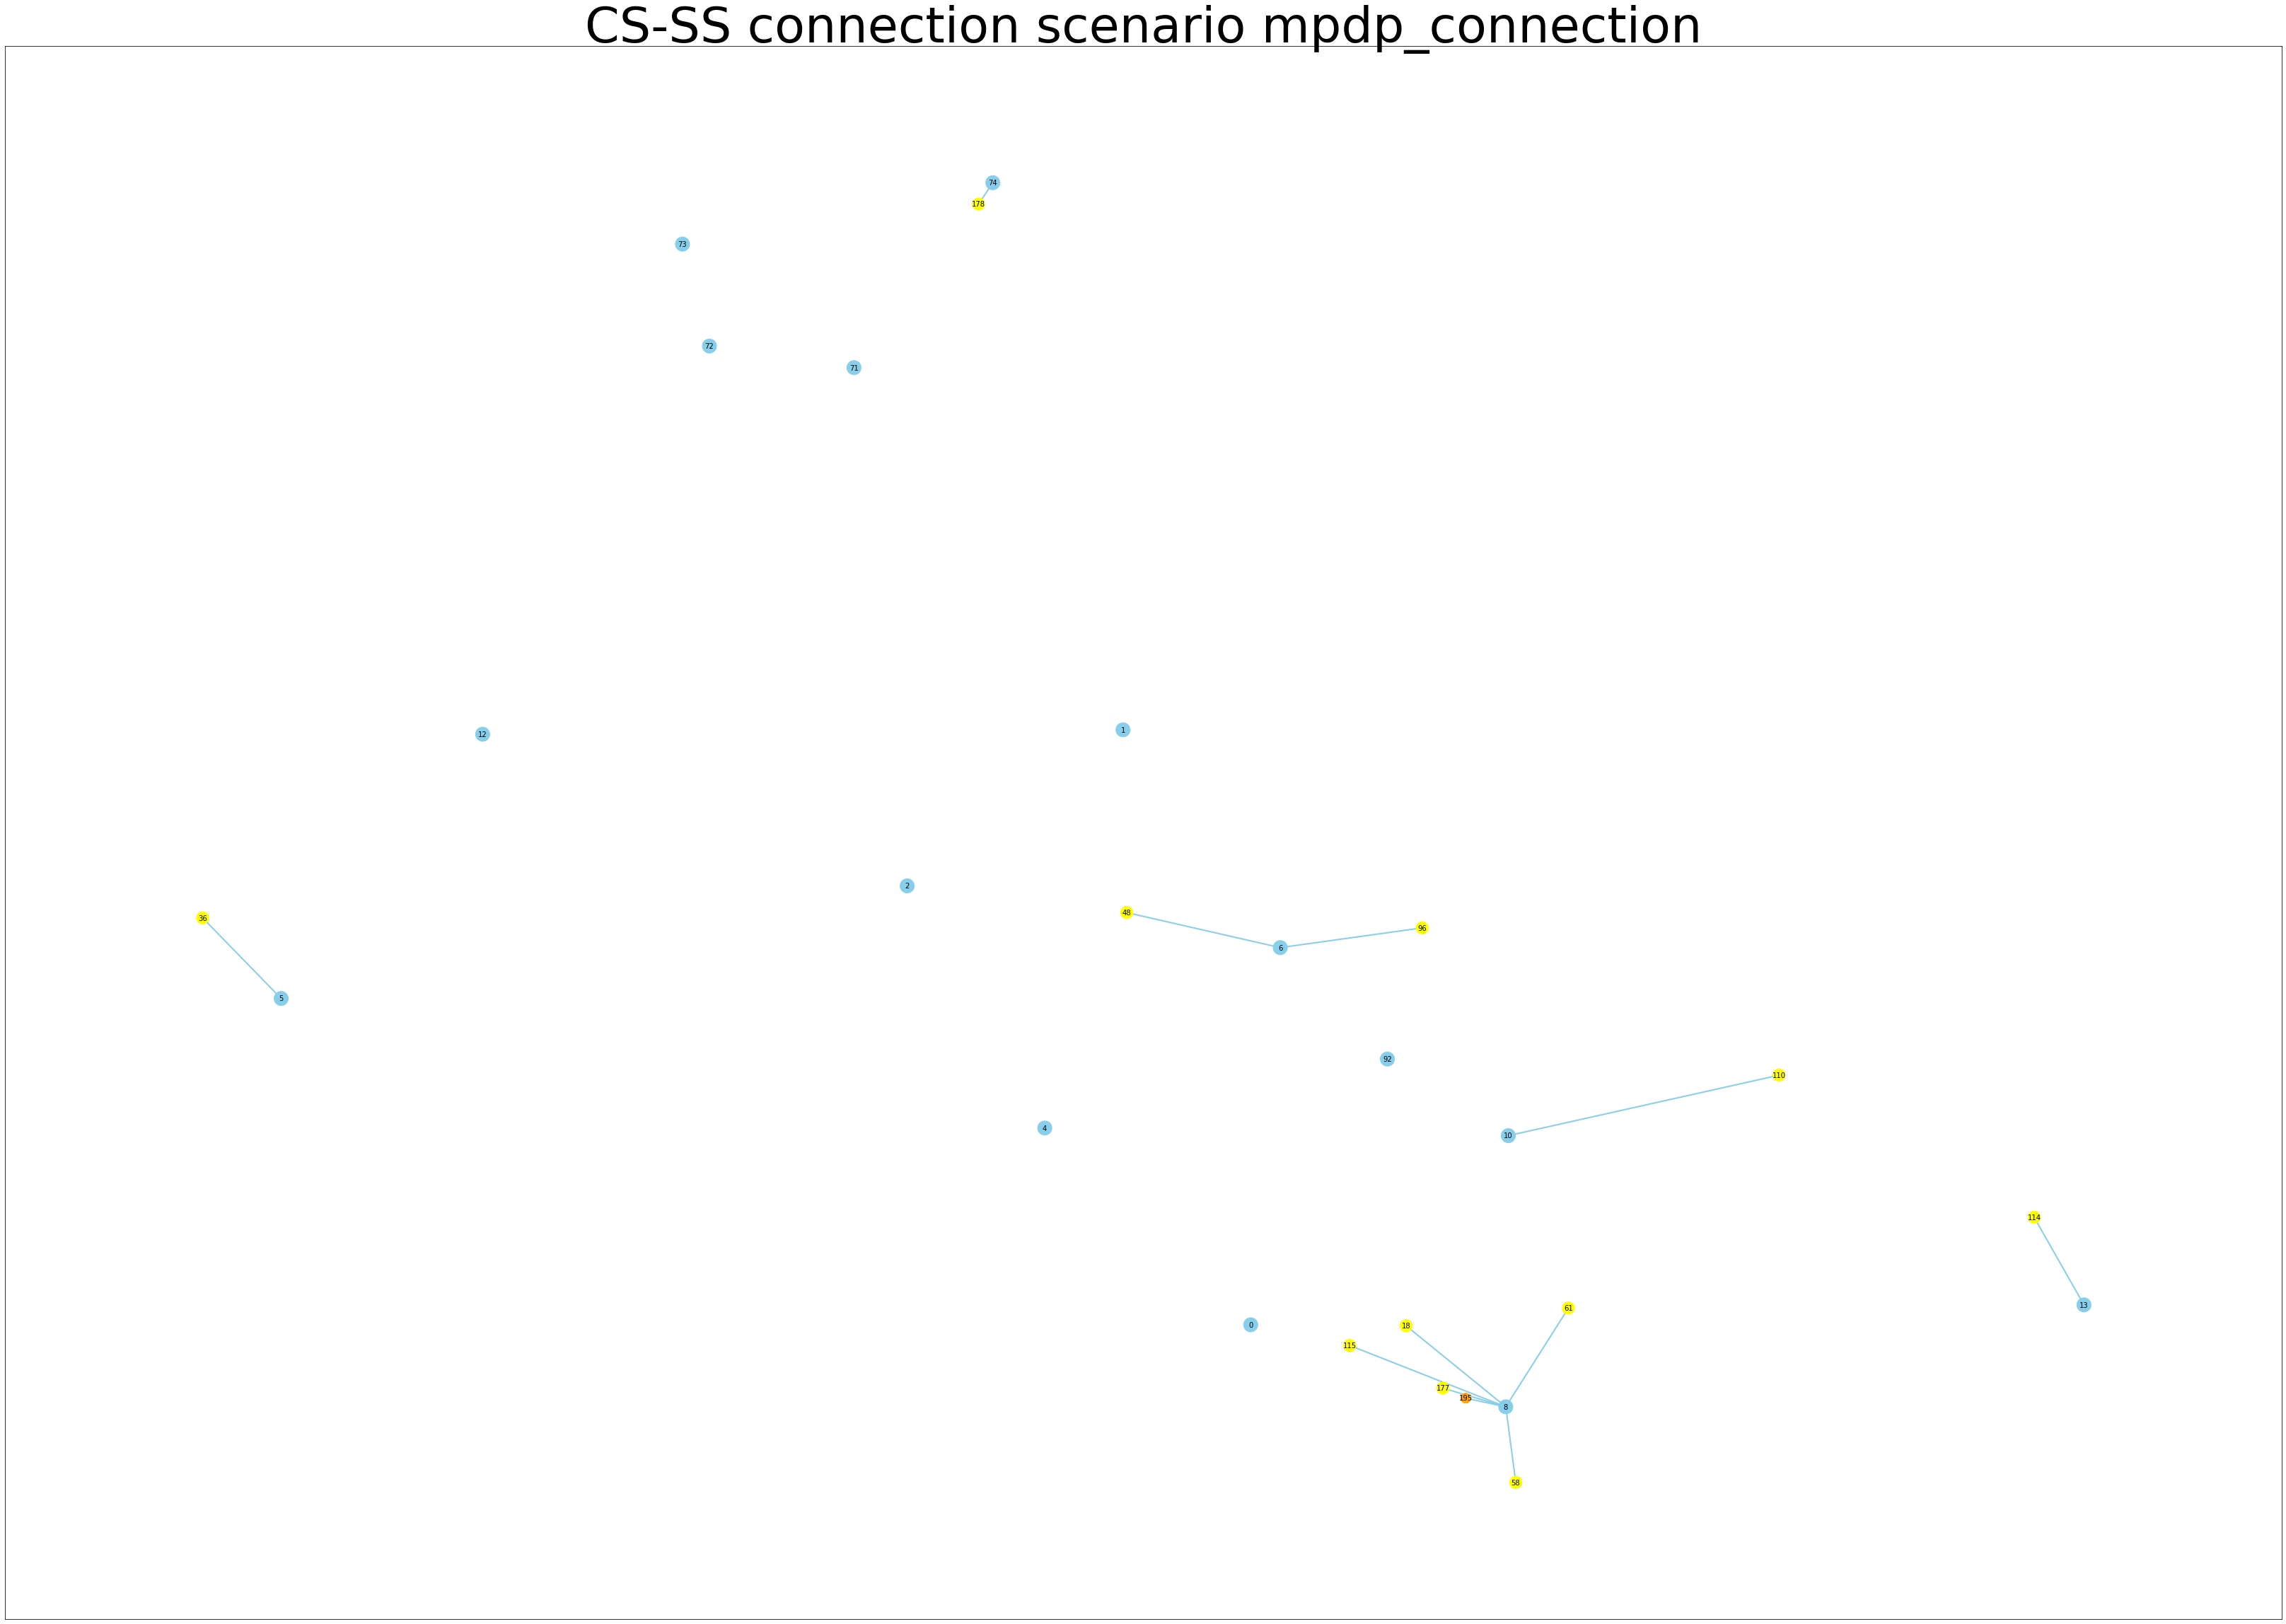

In [304]:
mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
Sceg._plot_cs_ss_connection_graph(
        cs_ss_con_sce_auxi_model, 
        mpdp_connection_dict, 'mpdp_connection'
        )

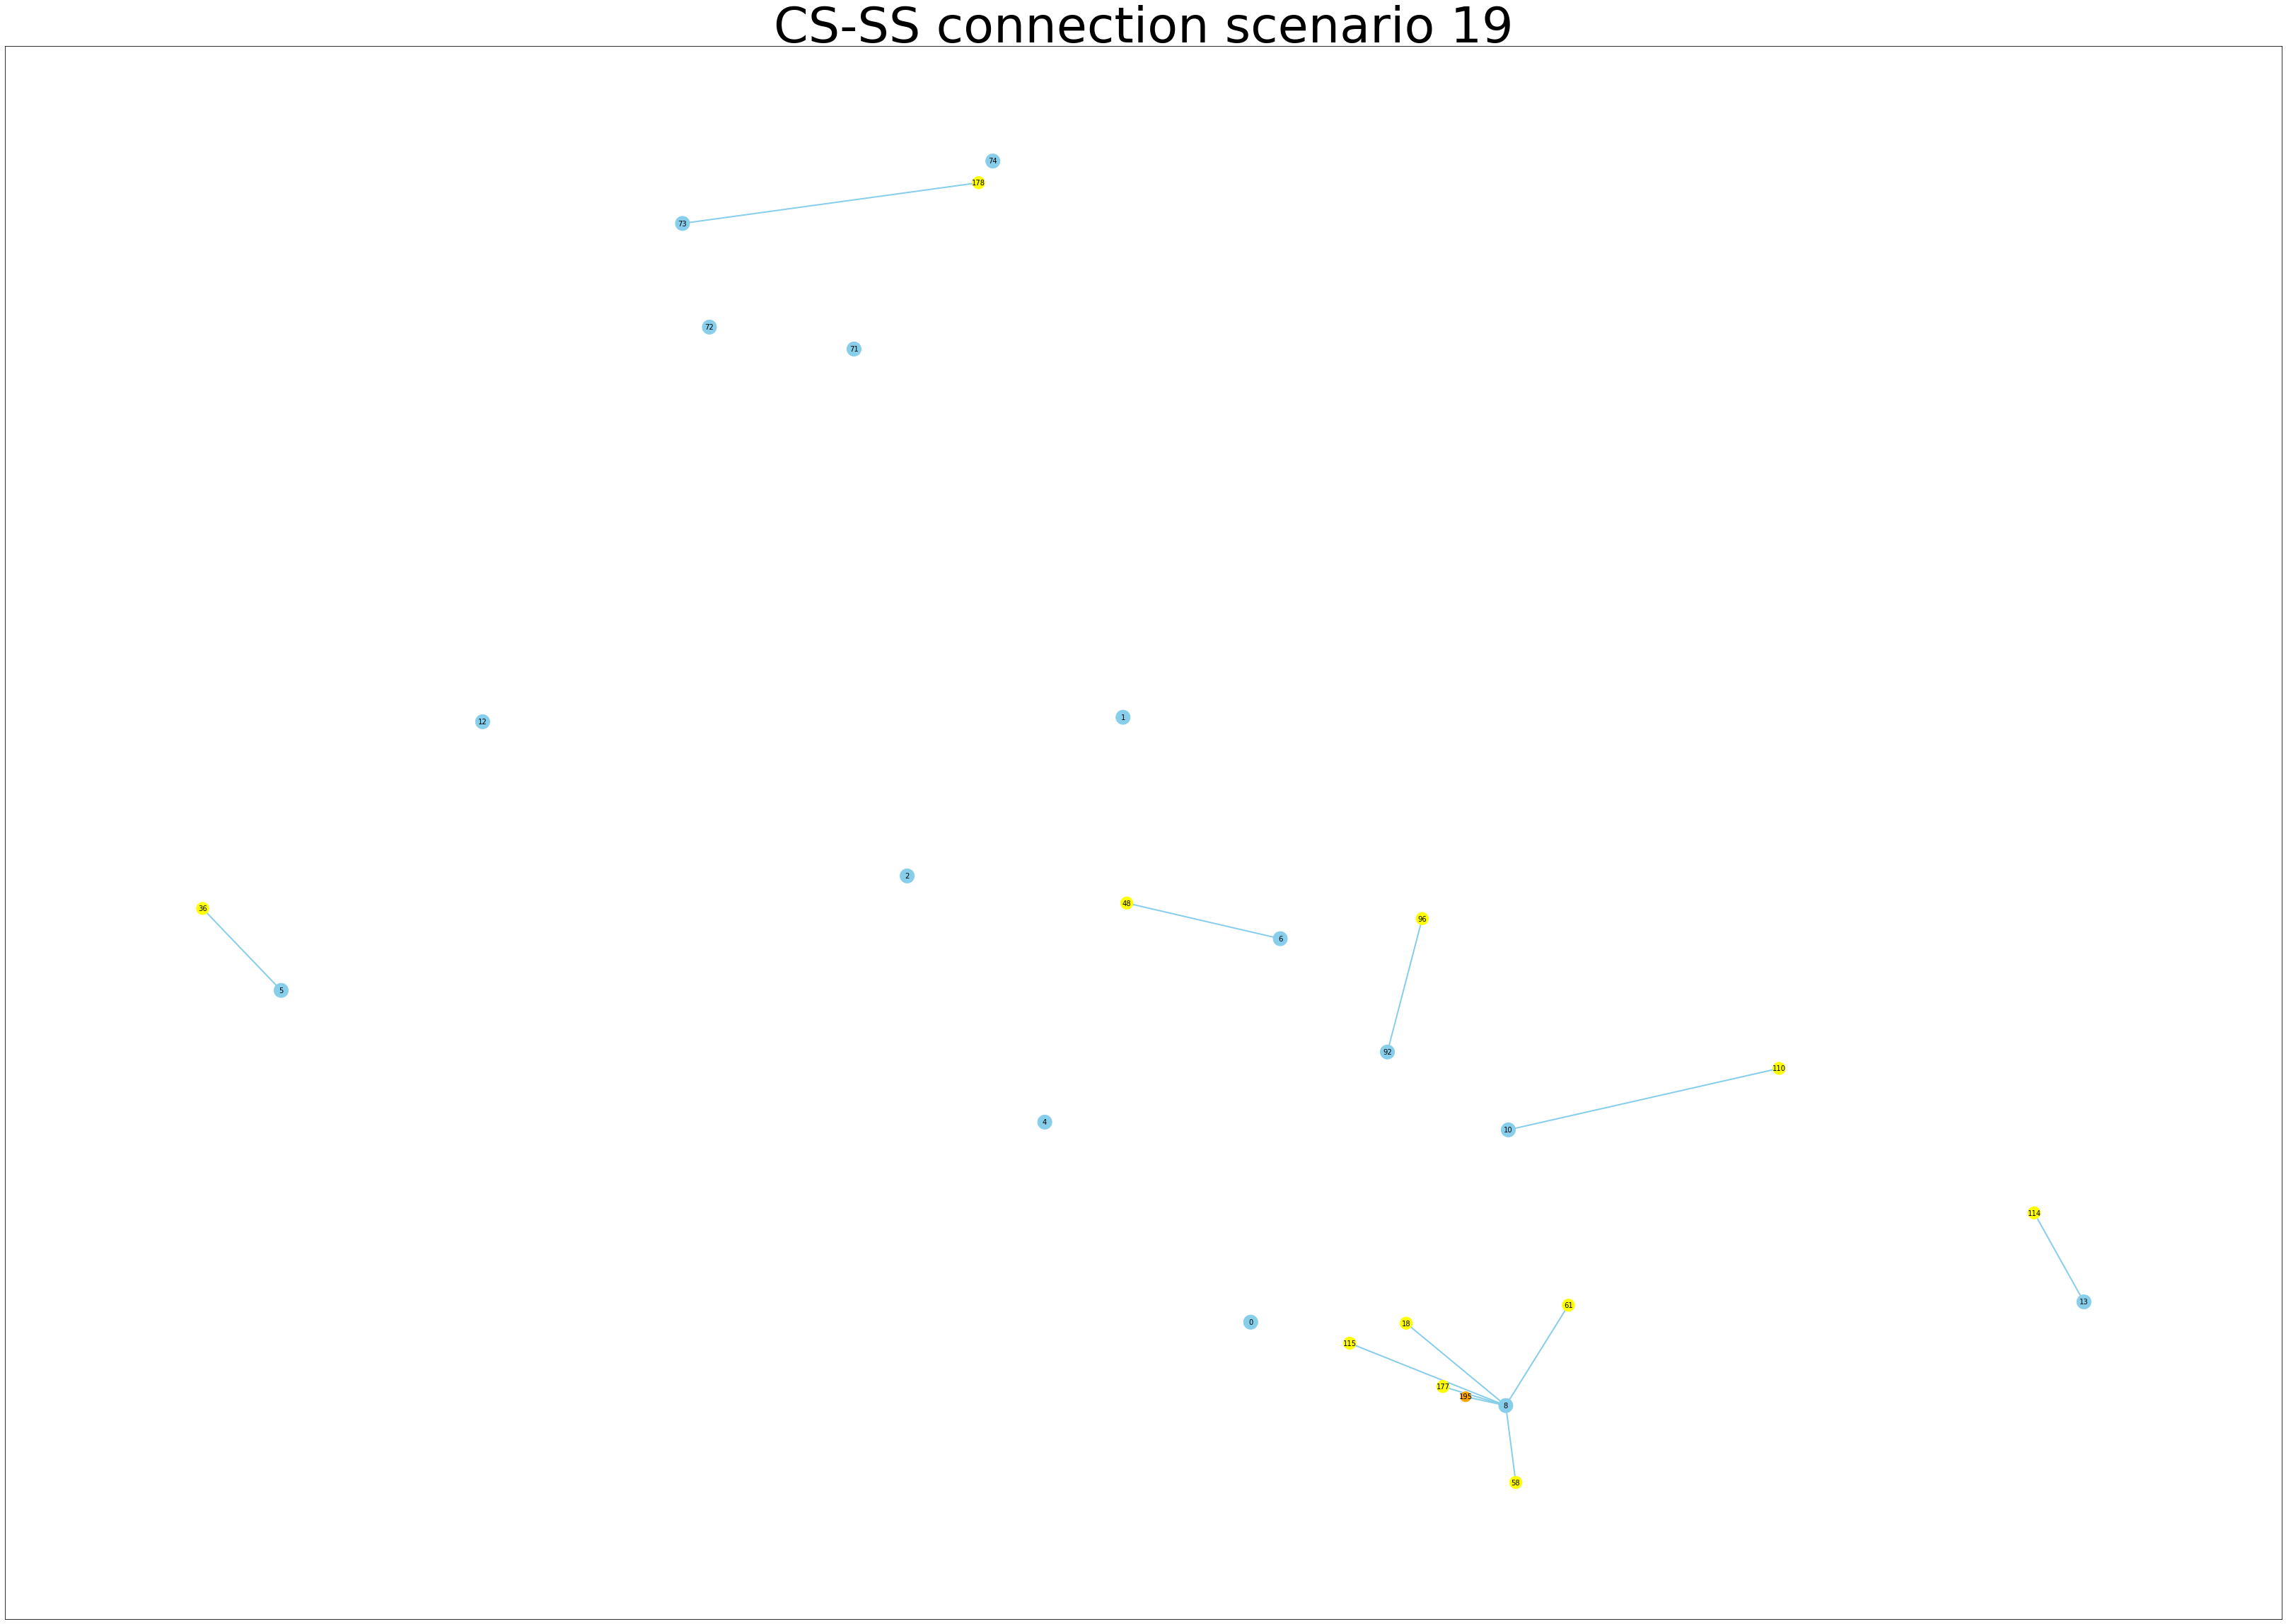

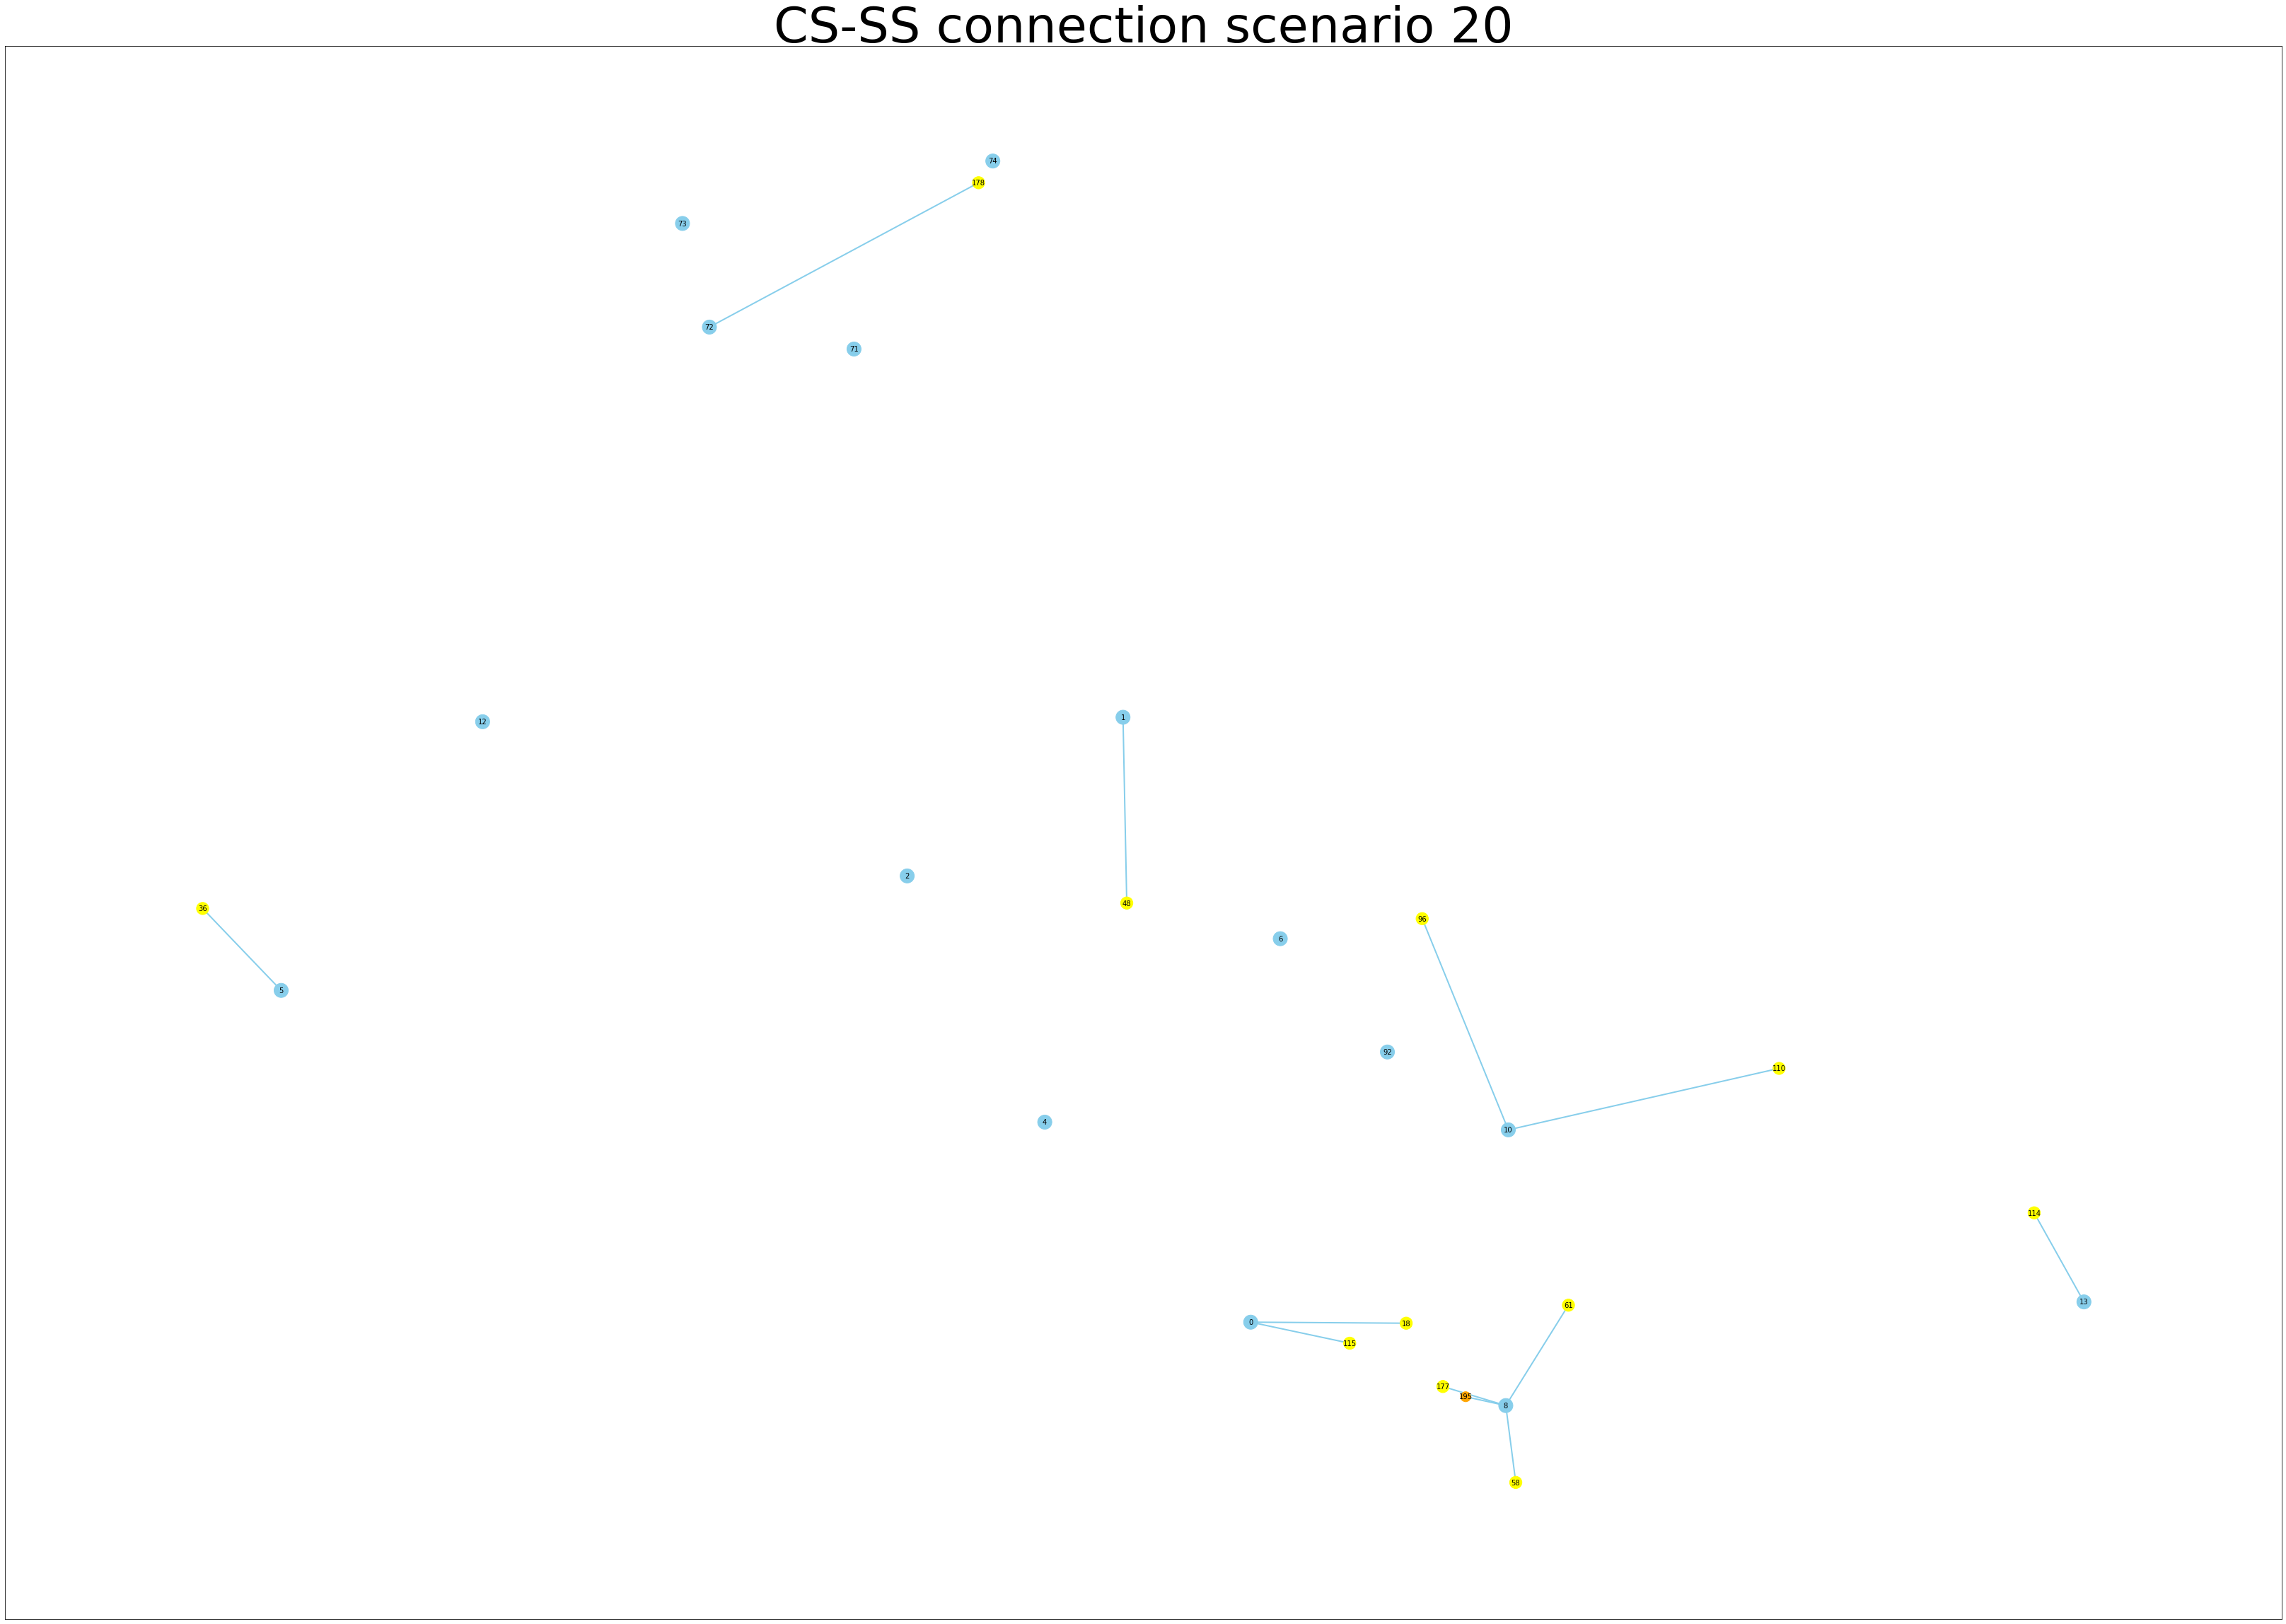

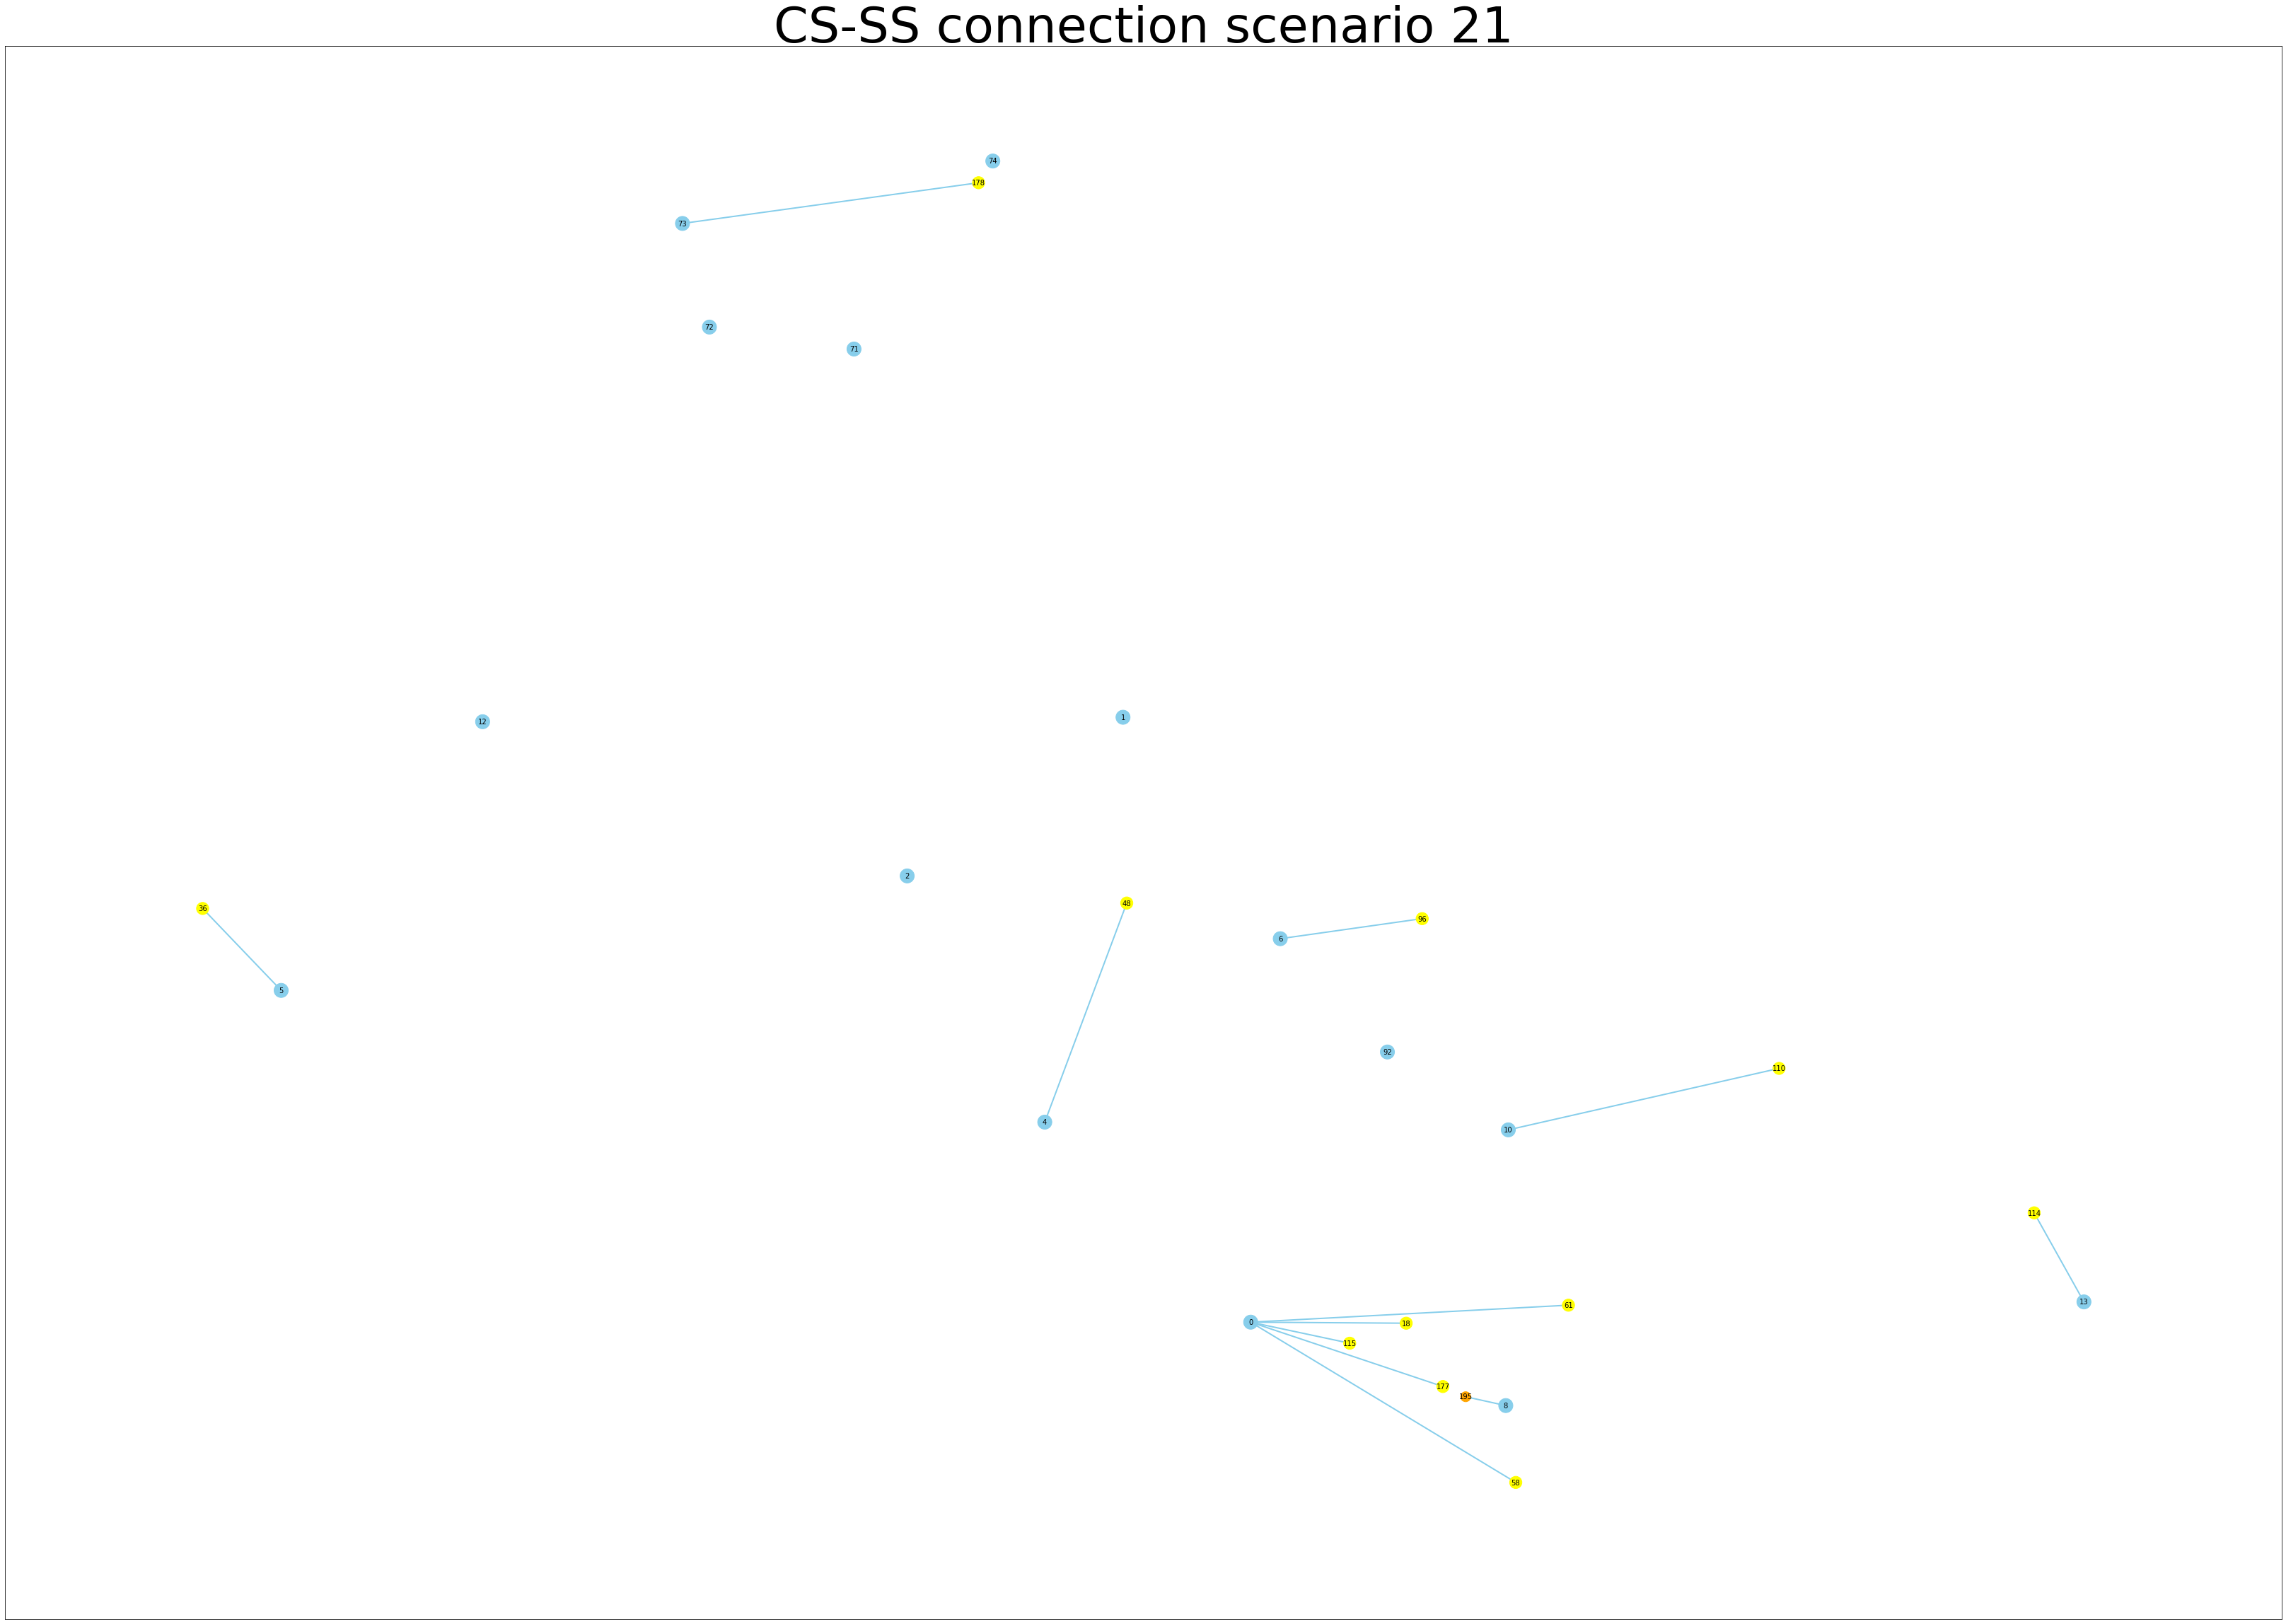

In [83]:
# sce_id = '19'
# # Sceg.
for sce_id in [str(i) for i in range(19,22)]:
    Sceg._plot_cs_ss_connection_graph(
        cs_ss_con_sce_auxi_model, 
        generated_scenarios, 
        sce_id
        )

In [45]:
str_phi_II_IJ_list = [f'{i}/60' for i in range(0,7)]
float_phi_II_IJ_list = [i/60 for i in range(0,7)]

vali_df_PHI_II_CS_115 = pd.DataFrame(index = str_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.K))
vali_df_PHI_II_CS_115.index.name = 'Phi_II (in hour)'
vali_df_PHI_II_CS_115.sort_index(axis=1, inplace = True)


vali_df_PHI_II_CS_58 = pd.DataFrame(index = str_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.K))
vali_df_PHI_II_CS_58.index.name = 'Phi_II (in hour)'
vali_df_PHI_II_CS_58.sort_index(axis=1, inplace = True)


vali_df_PHI_II_SS_10 = pd.DataFrame(index = str_phi_II_IJ_list, 
                              columns = list(va_cs_ss_con_sce_auxi_model.I))
vali_df_PHI_II_SS_10.index.name = 'Phi_II (in hour)'
vali_df_PHI_II_SS_10.sort_index(axis=1, inplace = True)


phi_II_test_dict = dict()

for idx, phi_II in enumerate(str_phi_II_IJ_list):
    copy_csap_setup_dict['params_cs']['phi_II'] = float_phi_II_IJ_list[idx]
    print(f"{idx}, {phi_II}, {copy_csap_setup_dict['params_cs']['phi_II']}")
    va_cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
        setup_dict = copy_csap_setup_dict
    )
    print(pyo.value(va_cs_ss_con_sce_auxi_model.phi_II))
    all_connection_sces_dict_vali = Sceg._generate_cs_ss_connection_sces(
        num_scenarios = 5000,
        auxi_model = va_cs_ss_con_sce_auxi_model,
        save_prob_matrices = False
        )
    
    total_conc_matrix_vali, _ = \
        Sceg._get_total_con_matrix_and_mpdp_con_sce(
            generated_connections = all_connection_sces_dict_vali
        )
    phi_II_test_dict[phi_II] = total_conc_matrix_vali
    vali_df_PHI_II_SS_10.iloc[idx, ] = total_conc_matrix_vali[10]
    vali_df_PHI_II_CS_58.iloc[idx, :] = total_conc_matrix_vali.loc[58,:]    
    vali_df_PHI_II_CS_115.iloc[idx, :] = total_conc_matrix_vali.loc[115,:]
with open('vali_7_phi_II_sces5k.pickle', 'wb') as f:
    pickle.dump(phi_II_test_dict, f)

0, 0/60, 0.0
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.16 seconds.
0.0


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [04:13<00:00, 19.73it/s]


1, 1/60, 0.016666666666666666
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.23 seconds.
0.016666666666666666


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [04:02<00:00, 20.58it/s]


2, 2/60, 0.03333333333333333
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.15 seconds.
0.03333333333333333


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [03:44<00:00, 22.22it/s]


3, 3/60, 0.05
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.12 seconds.
0.05


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [03:58<00:00, 20.94it/s]


4, 4/60, 0.06666666666666667
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.11 seconds.
0.06666666666666667


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [03:56<00:00, 21.17it/s]


5, 5/60, 0.08333333333333333
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.12 seconds.
0.08333333333333333


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [04:27<00:00, 18.72it/s]


6, 6/60, 0.1
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.22 seconds.
0.1


generating connection scenario: 100%|██████████████████████████████████████████████| 5000/5000 [04:05<00:00, 20.36it/s]


In [ ]:


import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go


def phi_II_vali():
    """ Just backup from Jupyternotebook in case for later usage.. Can't run it in .py script alone."""
    str_phi_II_IJ_list = [f'{i}/60' for i in range(0,7)]
    float_phi_II_IJ_list = [i/60 for i in range(0,7)]

    vali_df_PHI_II_CS_115 = pd.DataFrame(index = str_phi_II_IJ_list, 
                                columns = list(va_cs_ss_con_sce_auxi_model.K))
    vali_df_PHI_II_CS_115.index.name = 'Phi_II (in hour)'
    vali_df_PHI_II_CS_115.sort_index(axis=1, inplace = True)


    vali_df_PHI_II_CS_58 = pd.DataFrame(index = str_phi_II_IJ_list, 
                                columns = list(va_cs_ss_con_sce_auxi_model.K))
    vali_df_PHI_II_CS_58.index.name = 'Phi_II (in hour)'
    vali_df_PHI_II_CS_58.sort_index(axis=1, inplace = True)


    vali_df_PHI_II_SS_10 = pd.DataFrame(index = str_phi_II_IJ_list, 
                                columns = list(va_cs_ss_con_sce_auxi_model.I))
    vali_df_PHI_II_SS_10.index.name = 'Phi_II (in hour)'
    vali_df_PHI_II_SS_10.sort_index(axis=1, inplace = True)

    phi_II_test_dict = dict()

    for idx, phi_II in enumerate(str_phi_II_IJ_list):
        copy_csap_setup_dict['params_cs']['phi_II'] = float_phi_II_IJ_list[idx]
        print(f"{idx}, {phi_II}, {copy_csap_setup_dict['params_cs']['phi_II']}")
        va_cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
            setup_dict = copy_csap_setup_dict
        )
        print(pyo.value(va_cs_ss_con_sce_auxi_model.phi_II))
        all_connection_sces_dict_vali = Sceg._generate_cs_ss_connection_sces(
            num_scenarios = 5000,
            auxi_model = va_cs_ss_con_sce_auxi_model,
            save_prob_matrices = False
            )
        
        total_conc_matrix_vali, _ = \
            Sceg._get_total_con_matrix_and_mpdp_con_sce(
                generated_connections = all_connection_sces_dict_vali
            )
        phi_II_test_dict[phi_II] = total_conc_matrix_vali
        vali_df_PHI_II_SS_10.iloc[idx, ] = total_conc_matrix_vali[10]
        vali_df_PHI_II_CS_58.iloc[idx, :] = total_conc_matrix_vali.loc[58,:]    
        vali_df_PHI_II_CS_115.iloc[idx, :] = total_conc_matrix_vali.loc[115,:]
    with open('vali_7_phi_II_sces5k.pickle', 'wb') as f:
        pickle.dump(phi_II_test_dict, f)
    
droped_zero_vali_df_PHI_II_CS_115 = vali_df_PHI_II_CS_115.loc[:, (vali_df_PHI_II_CS_115>0).any(axis=0)]#.dropna(axis=1)
droped_zero_vali_df_PHI_II_CS_58 = vali_df_PHI_II_CS_58.loc[:, (vali_df_PHI_II_CS_58>0).any(axis=0)]#.dropna(axis=1)
droped_zero_vali_df_PHI_II_SS_10 = vali_df_PHI_II_SS_10.loc[:, (vali_df_PHI_II_SS_10>0).any(axis=0)]#.dropna(axis=1)







import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_CS_SS_connection(
    df: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph'
    ):
    df_copy = df.copy()
    columns = df_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': r'$\phi^{II} \; \text{[m]} $', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_copy, x=df_copy.index.astype(str), 
            y=columns, 
#             facet_col = columns,
#             title=plot_name, 
            text_auto = True,
            barmode = 'group', #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
            # marginal = "histogram",
            # marginal_y = "violin",
            # opacity = 0.7,                       
        )
#     print(plot_labels)

#         trace_cols_of_interest = ['sum']
#         for col in cols_of_interest:
#         fig.add_trace(
#              go.Scatter(
#         #          wide_df,
#                 x=df_copy.index, 
#                 y=df_copy[columns], 
#                 mode="lines",
#                 line=go.scatter.Line(
#         #          color="gray"
#              ),
#                 showlegend=True,
#                  opacity = 0.7,
# #                  name = f'sum'
#              )
#         )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.00,
        xanchor="auto",
        x=1.18
        ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
      legend_title_text='Connected SS ID',
          title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
     )
    fig.show()



## --------------------------------------------------------------------------------------------------------- ##

def _get_hourly_CD_cover_each_CP_atCSs(
        model: pyo.ConcreteModel
    ) -> tuple :
    """_summary_

    Args:
        model (pyo.ConcreteModel): _description_

    Returns:
        a tuple of two DataFrames: ()
    """
    # Get the df of CD_corverage for each period at each charging stations
    CD_coveraged_by_CSs_df = pd.Series({
        key:pyo.value(item_value) \
            for key, item_value in model.psi.extract_values().items()
    }).unstack()
    CD_coveraged_by_CSs_df = CD_coveraged_by_CSs_df[CD_coveraged_by_CSs_df>0].sort_index().dropna().astype(float)

    # Get the df of number of Charging points installed at each charging stations
    num_CPs_df = pd.Series({
        key: (pyo.value(item_value + model.n[key])) \
            for key, item_value in model.y.extract_values().items()
    })#.unstack()
    num_CPs_df = num_CPs_df[num_CPs_df>0].sort_index().astype(int)

    periods_length = np.array([22,2])

    # Get the df of CD_corverage for each period "of each single CP" at each charging stations
    period_cover_each_CP_at_CSs = CD_coveraged_by_CSs_df.divide(num_CPs_df, axis = 0)
    # Get the df of hourly avg. CD_corverage for each period "of each single CP" at each charging stations
    hourly_period_cover_each_CP_at_CSs = period_cover_each_CP_at_CSs/periods_length 
    return hourly_period_cover_each_CP_at_CSs, num_CPs_df



import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_phi_IJ_single_SP_CD_Cover(
    df: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph'
    ):
    df_copy = df.copy()
    columns = df_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': 'CS ID', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_copy, x=df_copy.index.astype(str), 
            y=columns, 
            text_auto = True,
            barmode = 'group', #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
        )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.00,
        xanchor="auto",
        x=1.18
        ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
    legend_title_text='Grid Period',
        title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    fig.show()


## --------------------------------------------------------------------------------------------------------- ##

def plot_phi_IJ_total_hourlyCD_Cover(
    df_1CP_CD_cov: pd.DataFrame,
    df_Nr_CPs: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph'
    ):
    df_1CP_CD_cov_copy = df_1CP_CD_cov.copy()
    columns = df_1CP_CD_cov_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': 'Grid Period', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_1CP_CD_cov_copy, x=df_1CP_CD_cov_copy.index.astype(str), 
            y=columns, 
#             facet_col = columns,
#             title=plot_name, 
#             text_auto = True,
            barmode = 'relative', #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
            # marginal = "histogram",
            # marginal_y = "violin",
            # opacity = 0.7,                       
        )
#     print(plot_labels)

#         trace_cols_of_interest = ['sum']
#         for col in cols_of_interest:
        fig.add_trace(
             go.Scatter(
        #          wide_df,
                x=df_1CP_CD_cov.index, 
                y=df_1CP_CD_cov.sum(axis = 1), 
#                 mode="lines",
#                 line=go.scatter.Line(
#                  color="gray"
#              ),
                showlegend=True,
#                  opacity = 0.7,
                 name = f'Sum',
             )
        )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.00,
        xanchor="auto",
        x=1.15
        ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
      legend_title_text='CS ID (Nr. CPs)',
          title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
     )
    fig.show()
